 Data Split Shapes:
  Training: (2915, 30), Validation: (625, 30), Testing: (625, 30)

📊 Validation/Test Results:
                      Model    R2_val   MAE_val  RMSE_val   R2_test  MAE_test  \
0         Linear Regression  0.171946  0.006849  0.009209  0.235191  0.006509   
1             Random Forest  0.906440  0.002366  0.003096  0.908995  0.002298   
2         Gradient Boosting  0.912519  0.002255  0.002993  0.910882  0.002258   
3                       SVR  0.017395  0.007688  0.010032 -0.000702  0.007452   
4          Mean Cd Baseline -0.000450  0.007736  0.010122 -0.001021  0.007481   
5  Neural Network (PyTorch) -0.021067  0.007786  0.010226 -0.031433  0.007514   

   RMSE_test  
0   0.008488  
1   0.002928  
2   0.002897  
3   0.009709  
4   0.009711  
5   0.009857  


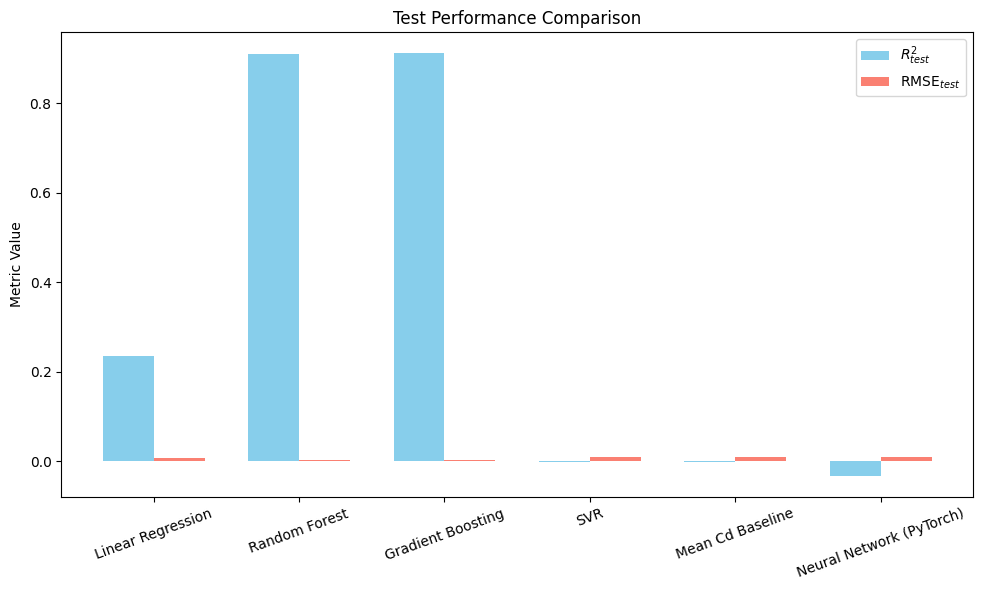

In [4]:
# --- Baseline Regression Models + Neural Network (70/15/15 Split) ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Load and preprocess dataset
try:
    df = pd.read_csv("DrivAerNet_ParametricData.csv")
except FileNotFoundError:
    print("Error: DrivAerNet_ParametricData.csv not found in current directory.")
    exit()

# Drop first column (Experiment) and NaNs
df = df.drop(columns=df.columns[0]).dropna()

# Split into features (B–X) and target (Y = Average Cd)
X = df.iloc[:, :-1].values.astype(np.float32)
y = df.iloc[:, -1].values.astype(np.float32)

#  Train/Val/Test Split: 70% / 15% / 15%
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f" Data Split Shapes:")
print(f"  Training: {X_train.shape}, Validation: {X_val.shape}, Testing: {X_test.shape}")

#  Define classical models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
    "SVR": SVR(C=1.0, epsilon=0.01)
}

#  Train and evaluate classical models
results = []

for name, model in models.items():
    model.fit(X_train, y_train)

    # Validation and Test Predictions
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    results.append({
        "Model": name,
        "R2_val": r2_score(y_val, y_val_pred),
        "MAE_val": mean_absolute_error(y_val, y_val_pred),
        "RMSE_val": np.sqrt(mean_squared_error(y_val, y_val_pred)),
        "R2_test": r2_score(y_test, y_test_pred),
        "MAE_test": mean_absolute_error(y_test, y_test_pred),
        "RMSE_test": np.sqrt(mean_squared_error(y_test, y_test_pred))
    })

#  Mean Cd baseline
y_val_mean = np.full_like(y_val, np.mean(y_train))
y_test_mean = np.full_like(y_test, np.mean(y_train))

results.append({
    "Model": "Mean Cd Baseline",
    "R2_val": r2_score(y_val, y_val_mean),
    "MAE_val": mean_absolute_error(y_val, y_val_mean),
    "RMSE_val": np.sqrt(mean_squared_error(y_val, y_val_mean)),
    "R2_test": r2_score(y_test, y_test_mean),
    "MAE_test": mean_absolute_error(y_test, y_test_mean),
    "RMSE_test": np.sqrt(mean_squared_error(y_test, y_test_mean))
})

#  Define Neural Network Model
class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

# Convert to tensors
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train).unsqueeze(1)
X_val_tensor = torch.from_numpy(X_val)
y_val_tensor = torch.from_numpy(y_val).unsqueeze(1)
X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize NN
net = Net(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

#  Train Neural Network
epochs = 500
for epoch in range(epochs):
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = net(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

# Evaluate Neural Network
with torch.no_grad():
    y_val_pred = net(X_val_tensor).numpy().flatten()
    y_test_pred = net(X_test_tensor).numpy().flatten()

results.append({
    "Model": "Neural Network (PyTorch)",
    "R2_val": r2_score(y_val, y_val_pred),
    "MAE_val": mean_absolute_error(y_val, y_val_pred),
    "RMSE_val": np.sqrt(mean_squared_error(y_val, y_val_pred)),
    "R2_test": r2_score(y_test, y_test_pred),
    "MAE_test": mean_absolute_error(y_test, y_test_pred),
    "RMSE_test": np.sqrt(mean_squared_error(y_test, y_test_pred))
})

#  Display Results
results_df = pd.DataFrame(results)
print("\n📊 Validation/Test Results:")
print(results_df)

#  Plot Comparison
plt.figure(figsize=(10,6))
x = np.arange(len(results_df))
bar_width = 0.35
plt.bar(x - bar_width/2, results_df["R2_test"], width=bar_width, label="$R^2_{test}$", color="skyblue")
plt.bar(x + bar_width/2, results_df["RMSE_test"], width=bar_width, label="RMSE$_{test}$", color="salmon")
plt.xticks(x, results_df["Model"], rotation=20)
plt.ylabel("Metric Value")
plt.title("Test Performance Comparison")
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
# ------------------- PINN + Classical Models with Physics Features -------------------
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

#  Load Data
df = pd.read_csv("DrivAerNet_ParametricData.csv")
df = df.drop(df.columns[0], axis=1)  # Drop 'Experiment' column
df = df.dropna()

X = df.iloc[:, :-1].values.astype(np.float32)  # Features B-X
y = df.iloc[:, -1].values.astype(np.float32)   # Average Cd

#  Split 70% Train, 15% Val, 15% Test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.17647, random_state=42)


#  Compute Physics Penalties
def compute_sample_penalties(X):
    n, d = X.shape
    eps = 1e-9
    U_inf, nu = 30.0, 1.56e-5

    def first_order_diff(vals):
        if vals.size < 2: return 0.0
        return np.mean((vals[1:] - vals[:-1])**2)

    def second_order_diff(vals):
        if vals.size < 3: return first_order_diff(vals)
        return np.mean((vals[2:] - 2*vals[1:-1] + vals[:-2])**2)

    def group_var(vals):
        if vals.size == 0: return 0.0
        return np.var(vals)

    # Indices
    ramp_idx, trunk_idx, roof_idx, front_idx, body_idx = [0,1,2],[11,12],[21,22],[13,14],[18,20]
    fender_idx, rear_wake_idx, rear_side_idx, ramp_diff_idx = [10,17],[2,4,9,10,11,12,17],[20,21,22],[0,1]

    L_slopes, L_smooth, L_stream, L_wake, L_reynolds = np.zeros(n), np.zeros(n), np.zeros(n), np.zeros(n), np.zeros(n)
    for i in range(n):
        row = X[i,:]
        def pick(idx): return np.array([row[j] for j in idx if j<d])
        L_slopes[i] = np.mean([first_order_diff(pick(ramp_idx)),
                               first_order_diff(pick(trunk_idx)),
                               first_order_diff(pick(roof_idx)),
                               first_order_diff(pick(front_idx)),
                               first_order_diff(pick(body_idx))])
        L_smooth[i] = np.mean([second_order_diff(pick(front_idx)),
                               second_order_diff(pick(ramp_idx)),
                               second_order_diff(pick([2,11,12])),
                               second_order_diff(pick(roof_idx)),
                               second_order_diff(pick(fender_idx))])
        L_stream[i] = np.mean([group_var(pick(ramp_diff_idx)),
                               group_var(pick([2,11,12])),
                               group_var(pick(roof_idx)),
                               group_var(pick([13])),
                               group_var(pick(fender_idx))])
        L_wake[i] = np.mean([second_order_diff(pick(rear_wake_idx)),
                             second_order_diff(pick(rear_side_idx))])
        if 18<d:
            L_car = max(row[18],1e-6)
            ReL = U_inf*L_car/nu
            L_reynolds[i] = np.log1p(ReL)
        else: L_reynolds[i] = 0.0

    P = np.vstack([L_slopes,L_smooth,L_stream,L_wake,L_reynolds]).T
    return (P - P.mean(axis=0))/ (P.std(axis=0)+1e-9)

# Compute penalties
P_train = compute_sample_penalties(X_train)
P_val   = compute_sample_penalties(X_val)
P_test  = compute_sample_penalties(X_test)

# Augment features for classical models
X_train_aug = np.hstack([X_train, P_train])
X_val_aug   = np.hstack([X_val,   P_val])
X_test_aug  = np.hstack([X_test,  P_test])

#  Classical Models
classical_models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
    "SVR": SVR(C=1.0, epsilon=0.01)
}

results = []
for name, model in classical_models.items():
    model.fit(X_train_aug, y_train)
    y_val_pred = model.predict(X_val_aug)
    y_test_pred = model.predict(X_test_aug)
    results.append({
        "Model": name,
        "R2_val": r2_score(y_val,y_val_pred),
        "MAE_val": mean_absolute_error(y_val,y_val_pred),
        "RMSE_val": np.sqrt(mean_squared_error(y_val,y_val_pred)),
        "R2_test": r2_score(y_test,y_test_pred),
        "MAE_test": mean_absolute_error(y_test,y_test_pred),
        "RMSE_test": np.sqrt(mean_squared_error(y_test,y_test_pred))
    })

#  PINN Neural Network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,1)
        )
    def forward(self,x): return self.net(x)

nn_model = MLP(X_train.shape[1]).to(device)
nn_opt = optim.Adam(nn_model.parameters(), lr=1e-3)
mse = nn.MSELoss(reduction='mean')

# Initialize weights for penalties
raw_weights = [nn.Parameter(torch.tensor(0.0,device=device)) for _ in range(5)]
weight_opt = optim.Adam(raw_weights, lr=0.1)  # Increment = 0.1

def positive(x): return torch.nn.functional.softplus(x)

def compute_batch_penalties_tensor(Xb, preds):
    # Xb: (B,d), preds: (B,)
    if preds.ndim==2: preds=preds.view(-1)
    device = Xb.device

    def first_order_diff_t(group):
        if group.shape[1]<2: return torch.tensor(0.0,device=device)
        return torch.mean((group[:,1:] - group[:,:-1])**2)
    def second_order_diff_t(group):
        if group.shape[1]<3: return first_order_diff_t(group)
        return torch.mean((group[:,2:] -2*group[:,1:-1]+group[:,:-2])**2)
    def var_t(group):
        if group.shape[1]<1: return torch.tensor(0.0,device=device)
        return torch.mean((group - torch.mean(group,dim=1,keepdim=True))**2)

    ramp = Xb[:, [0,1,2]]; trunk = Xb[:, [11,12]]; roof = Xb[:, [21,22]]
    front = Xb[:, [13,14]]; body = Xb[:, [18,20]]; fender = Xb[:, [10,17]]
    rear_wake = Xb[:, [2,4,9,10,11,12,17]]; rear_side = Xb[:, [20,21,22]]
    ramp_diff = Xb[:, [0,1]]

    L_slopes = torch.mean(torch.stack([first_order_diff_t(ramp), first_order_diff_t(trunk),
                                      first_order_diff_t(roof), first_order_diff_t(front),
                                      first_order_diff_t(body)]))
    L_smooth = torch.mean(torch.stack([second_order_diff_t(front), second_order_diff_t(ramp),
                                       second_order_diff_t(trunk), second_order_diff_t(roof),
                                       second_order_diff_t(fender)]))
    L_stream = torch.mean(torch.stack([var_t(ramp_diff), var_t(trunk), var_t(roof), var_t(front), var_t(fender)]))
    L_wake = torch.mean(torch.stack([second_order_diff_t(rear_wake), second_order_diff_t(rear_side)]))
    # Reynolds
    L_reynolds = torch.var(preds / (Xb[:,18].clamp(min=1e-6)*30.0/1.56e-5 + 1e-6)) if Xb.shape[1]>18 else torch.tensor(0.0,device=device)

    return [L_slopes,L_smooth,L_stream,L_wake,L_reynolds]

# Training loop
num_epochs = 150
for epoch in range(1,num_epochs+1):
    nn_model.train()
    for Xb,yb in train_loader:
        Xb,yb = Xb.to(device), yb.to(device)
        nn_opt.zero_grad()
        preds = nn_model(Xb).view(-1)
        Ls = compute_batch_penalties_tensor(Xb, preds)
        ws,wl,wst,wwake,wr = [positive(p) for p in raw_weights]
        loss = torch.sqrt(mse(preds,yb)+1e-12) + ws*Ls[1] + wl*Ls[0] + wst*Ls[2] + wwake*Ls[3] + wr*Ls[4]
        loss.backward()
        nn_opt.step()

# Evaluation
nn_model.eval()
all_preds = []
with torch.no_grad():
    for Xb,_ in test_loader:
        all_preds.append(nn_model(Xb.to(device)).view(-1).cpu().numpy())
y_pred_nn = np.concatenate(all_preds)
results.append({
    "Model": "PINN (NN + penalty weights)",
    "R2_val": r2_score(y_val,np.concatenate([nn_model(X_val_tensor).detach().numpy().flatten()])),
    "MAE_val": mean_absolute_error(y_val,np.concatenate([nn_model(X_val_tensor).detach().numpy().flatten()])),
    "RMSE_val": np.sqrt(mean_squared_error(y_val,np.concatenate([nn_model(X_val_tensor).detach().numpy().flatten()]))),
    "R2_test": r2_score(y_test,y_pred_nn),
    "MAE_test": mean_absolute_error(y_test,y_pred_nn),
    "RMSE_test": np.sqrt(mean_squared_error(y_test,y_pred_nn))
})

#  Present Results
results_df = pd.DataFrame(results)
print(results_df)


                         Model    R2_val   MAE_val  RMSE_val   R2_test  \
0            Linear Regression  0.915977  0.002261  0.002892  0.929067   
1                Random Forest  0.904826  0.002389  0.003078  0.916120   
2            Gradient Boosting  0.909581  0.002313  0.003000  0.922400   
3                          SVR  0.001511  0.007707  0.009969 -0.022427   
4  PINN (NN + penalty weights) -0.068208  0.007736  0.010311 -0.080830   

   MAE_test  RMSE_test  
0  0.002069   0.002646  
1  0.002203   0.002877  
2  0.002092   0.002768  
3  0.007757   0.010046  
4  0.007665   0.010329  
